###### Copyright (c)2015 DiGangi, C.

# Managing Epidemics Through Mathematical Modeling

This lesson will examine the spread of an epidemic over time using Euler's method. The model is a system of non-linear ODEs which is based on the classic Susceptible, Infected, Recovered (SIR) model. This model introduces a new parameter  to include vaccinations. We will examine the various paremeters of the model and define conditions necessary to erradicate the epidemic.

In this module we will also introduce ipywigets, an IPython library that allows you to add widgets to your notebooks and make them interactive! We will be using widgets to vary our parameters and see how changing different parameters affects the results of the model. This is a great technique for making quick and easy comparisons because you don't have to re-run your cell for the widget to make changes to the graph. 

## Introducing Model Parameters

The most important part of understanding any model is understanding the nomenclature that is associated with it. Please review the below terms carefully and make sure you understand what each parameter represents.

$S$: Susceptible Individuals

$V$: Vaccinated Individuals

$I$: Infected Individuals

$R$: Recovered Individuals with Immunity (Cannot get infected again)

$p$: Fraction of individuals who are vaccinated at birth 

$e$: Fraction of the vaccinated individuals that are successfully vaccinated

$\mu$: Average Death Rate

$\beta$: Contact Rate (Rate at which Susceptibles come into contact with Infected)

$\gamma$: Recovery Rate

$R_0$: Basic Reporoduction Number

$N$: Total Population ($S + V + I + R$)



## Basic SVIR Model

## Model Assumptions
The model will make the following assumptions:

- The population N is held constant
- The birth rate and death rate are equal
- The death rate is the same across all individuals (Infected do not have higher death rate)
- A susceptible individual that comes in contact with an infected automatically becomes infected
- Once an individual has recovered they are forever immune and not reintroduced into the susceptible population
- Vaccination does not wear off (vaccinated cannot become infected)



### Susceptible Equation
Let's examine the model by component. First we will breakdown the equation for susceptible individuals. In order to find the rate of change of susceptible individuals we must calculate the number of newborns that are not vaccinated:

$$(1-ep) \mu N$$

The number of Susceptible Individuals that become infected:

$$ \beta IS_{infections}$$

and finally the number of Susceptibles that die:

$$ \mu S_{deaths}$$

Therefore the change in Susceptible Indivduals becomes:

$$\frac{dS}{dt} = (1-ep) \mu N - \beta IS - \mu S$$



### Vaccinated Equation

Now examining the vaccinated individuals we start with the newborns that are vaccinated:

$$ep \mu N$$

And the number of vaccinated individuals that die:

$$\mu V$$

The change in vaccinated individuals becomes:

$$\frac{dV}{dt} = ep \mu N - \mu V$$

### Infected Equation

For the infected individuals we start with the number of Susceptible individuals that are exposed and become infected:

$$\beta IS_{infections}$$

Next we need the number of Infected individuals that recovered:

$$\gamma I_{recoveries}$$

Finally we examine the infected who die:

$$\mu I_{deaths}$$

Putting this all together we get the following equation:

$$\frac{dI}{dt} = \beta IS - \gamma I - \mu I$$

### Recovered Equation

The number of recovered individuals first relies on the infected who recover:

$$\gamma I$$

Next it depeds on the recovered individuals who die:

$$\mu R$$

Putting this together yeilds the equation:

$$\frac{dR}{dt} = \gamma I - \mu R$$

## Model Summary

The complete model is as follows:

$$\frac{dS}{dt} = (1-ep) \mu N - \beta IS - \mu S$$

$$\frac{dV}{dt} = ep \mu N - \mu V$$

$$\frac{dI}{dt} = \beta IS - \gamma I - \mu I$$

$$\frac{dR}{dt} = \gamma I - \mu R$$

This is a very simplified model because of the complexities of infectious diseases. 

## Implementing Numerical Solution with Euler!

For the numerical solution we will be using Euler's method since we are only dealing with time derivatives. Just to review, for Euler's method we replace the time derivative by the following:

$$\frac{dS}{dt} = \frac{S^{n+1} - S^n}{\Delta t}$$

where n represents the discretized time.

Therefore after we discretize our model we have:

$$\frac{S^{n+1} - S^n}{\Delta t} = (1-ep) \mu N - \beta IS^n - \mu S^n$$

$$\frac{V^{n+1} - V^n}{\Delta t} = ep \mu N - \mu V^n$$

$$\frac{I^{n+1} - I^n}{\Delta t} = \beta I^nS^n - \gamma I^n - \mu I^n$$

$$\frac{R^{n+1} - R^n}{\Delta t} = \gamma I^n - \mu R^n$$

And now solving for the value at the next time step yeilds:

$$S^{n+1}  = S^n + \Delta t \left((1-ep) \mu N - \beta IS^n - \mu S^n \right)$$

$$V^{n+1} = V^n +  \Delta t ( ep \mu N - \mu V^n)$$

$$I^{n+1} = I^n + \Delta t (\beta I^nS^n - \gamma I^n - \mu I^n)$$

$$R^{n+1}  = R^n + \Delta t ( \gamma I^n - \mu R^n)$$

If we want to implement this into our code we can build arrays to hold our system of equations. Assuming u is our solution matrix and f(u) is our right hand side:

\begin{align}
u & = \begin{pmatrix} S \\ V \\ I \\ R \end{pmatrix} & f(u) & = \begin{pmatrix} S^n + \Delta t \left((1-ep) \mu N - \beta IS^n - \mu S^n \right) \\ V^n +  \Delta t ( ep \mu N - \mu V^n) \\ I^n + \Delta t (\beta I^nS^n - \gamma I^n - \mu I^n) \\ R^n + \Delta t ( \gamma I^n - \mu R^n) \end{pmatrix}.
\end{align}

## Solve!

Now we will implement this solution below. First we will import the necessary python libraries

In [18]:
%matplotlib inline
import numpy 
from matplotlib import pyplot
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

Let us first define our function $f(u)$ that will calculate the right hand side of our model. We will pass in the array $u$ which contains our different populations and set them individually in the function:

In [19]:
def f(u):
    """Returns the right-hand side of the epidemic model equations.
    
    Parameters
    ----------
    u : array of float
        array containing the solution at time n.
        u is passed in and distributed to the different components by calling the individual value in u[i]
        
    Returns
    -------
    du/dt : array of float
        array containing the RHS given u.
    """
    
    S = u[0]
    V = u[1]
    I = u[2]
    R = u[3]
    
    return numpy.array([(1-e*p)*mu*N - beta*I*S - mu*S,
                       e*p*mu*N - mu*V,
                       beta*I*S - gamma*I - mu*I,
                       gamma*I - mu*R])

Next we will define the euler solution as a function so that we can call it as we iterate through time.

In [20]:
def euler_step(u, f, dt):
    
    """Returns the solution at the next time-step using Euler's method.
    
    Parameters
    ----------
    u : array of float
        solution at the previous time-step.
    f : function
        function to compute the right hand-side of the system of equation.
    dt : float
        time-increment.
    
    Returns
    -------
        approximate solution at the next time step.
    """
    
    return u + dt * f(u)

Now we are ready to set up our initial conditions and solve! We will use a simplified population to start with.

In [21]:
e = .1 #vaccination success rate
p = .75 # newborn vaccination rate
mu = .02 # death rate
beta = .002 # contact rate
gamma = .5 # Recovery rate

S0 = 100 # Initial Susceptibles
V0 = 50 # Initial Vaccinated
I0 = 75 # Initial Infected
R0 = 10 # Initial Recovered

N = S0 + I0 + R0 + V0 #Total population (remains constant)

Now we will implement our discretization using a for loop to iterate over time. We create a numpy array $u$ that will hold all of our values at each time step for each component (SVIR). We will use dt of 1 to represent 1 day and iterate over 365 days. 

In [22]:
T = 365 # Iterate over 1 year
dt = 1 # 1 day
N = int(T/dt)+1 # Total number of iterations
t = numpy.linspace(0, T, N) # Time discretization

u = numpy.zeros((N,4)) # Initialize the solution array with zero values
u[0] = [S0, V0, I0, R0] # Set the initial conditions in the solution array

for n in range(N-1): # Loop through time steps
    u[n+1] = euler_step(u[n], f, dt) # Get the value for the next time step using our euler_step function



Now we use python's pyplot library to plot all of our results on the same graph:

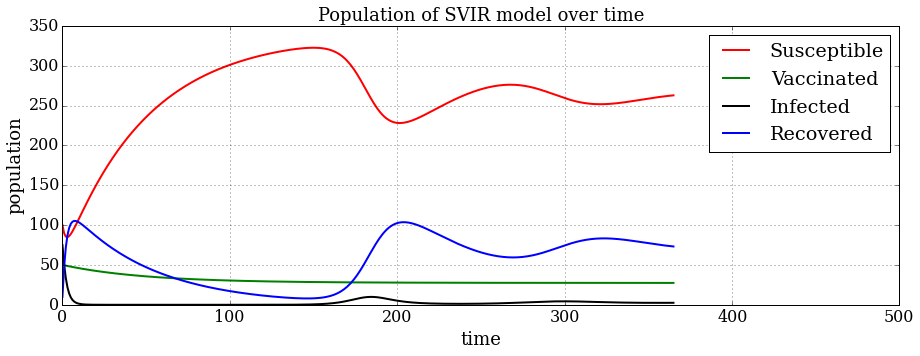

In [23]:
pyplot.figure(figsize=(15,5))
pyplot.grid(True)
pyplot.xlabel(r'time', fontsize=18)
pyplot.ylabel(r'population', fontsize=18)
pyplot.xlim(0, 500)
pyplot.title('Population of SVIR model over time', fontsize=18)
pyplot.plot(t,u[:,0], color= 'red', lw=2, label = 'Susceptible');
pyplot.plot(t,u[:,1], color='green', lw=2, label = 'Vaccinated');
pyplot.plot(t,u[:,2], color='black', lw=2, label = 'Infected');
pyplot.plot(t,u[:,3], color='blue', lw=2, label = 'Recovered');
pyplot.legend();

The graph is interesting because it exhibits some oscillating behavior. You can see that under the given parameters, the number of infected people drops within the first few days. Notice that the susceptible individuals grow until about 180 days. The return of infection is a result of too many susceptible people in the population. The number of infected looks like it goes to zero but it never quite reaches zero. Therfore, when we have $\beta IS$, when $S$ gets large enough the infection will start to be reintroduced into the population.

If we want to examine how the population changes under new conditions, we could re-run the below cell with new parameters:

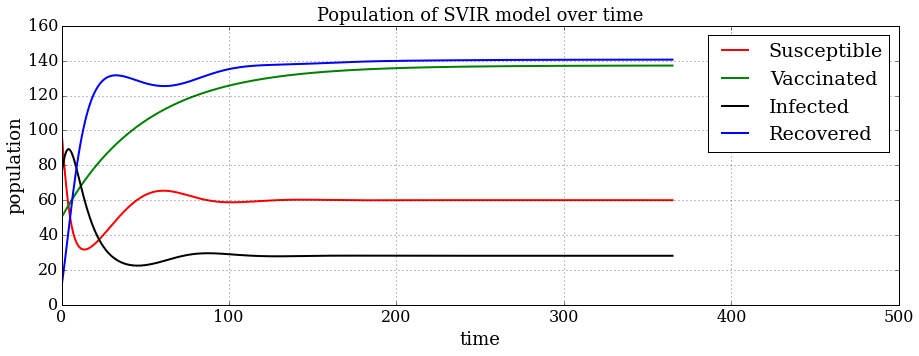

In [24]:
#Changing the following parameters
e = .5 #vaccination success rate
gamma = .1 # Recovery rate

S0 = 100 # Initial Susceptibles
V0 = 50 # Initial Vaccinated
I0 = 75 # Initial Infected
R0 = 10 # Initial Recovered

N = S0 + I0 + R0 + V0 #Total population (remains constant)

T = 365 # Iterate over 1 year
dt = 1 # 1 day
N = int(T/dt)+1 # Total number of iterations
t = numpy.linspace(0, T, N) # Time discretization

u = numpy.zeros((N,4)) # Initialize the solution array with zero values
u[0] = [S0, V0, I0, R0] # Set the initial conditions in the solution array

for n in range(N-1): # Loop through time steps
    u[n+1] = euler_step(u[n], f, dt) # Get the value for the next time step using our euler_step function
    
pyplot.figure(figsize=(15,5))
pyplot.grid(True)
pyplot.xlabel(r'time', fontsize=18)
pyplot.ylabel(r'population', fontsize=18)
pyplot.xlim(0, 500)
pyplot.title('Population of SVIR model over time', fontsize=18)
pyplot.plot(t,u[:,0], color= 'red', lw=2, label = 'Susceptible');
pyplot.plot(t,u[:,1], color='green', lw=2, label = 'Vaccinated');
pyplot.plot(t,u[:,2], color='black', lw=2, label = 'Infected');
pyplot.plot(t,u[:,3], color='blue', lw=2, label = 'Recovered');
pyplot.legend();

However, every time we want to examine new parameters we have to go back and change the values within the cell and re run our code. This is very cumbersome if we want to examine how different parameters affect our outcome. If only there were some solution we could implement that would allow us to change parameters on the fly without having to re-run our code...

## ipywidgets!

Well there is a solution we can implement! Using a python library called ipywidgets we can build interactive widgets into our notebook that allow for user interaction. If you do not have ipywidets installed, you can install it using conda by simply going to the terminal and typing:

conda install ipywidgets

Now we will import our desired libraries

In [25]:
from ipywidgets import interact, HTML, FloatSlider
from IPython.display import clear_output, display

The below cell is a quick view of a few different interactive widgets that are available. Notice that we must define a function (in this case $z$) where we call the function $z$ and parameter $x$, where $x$ is passed into the function $z$.

In [26]:
def z(x):
    print(x)
interact(z, x=True) # Checkbox
interact(z, x=10) # Slider 
interact(z, x='text') # Text entry




text


<function __main__.z>

# Redefining the Model to Accept Parameters

In order to use ipywidgets and pass parameters in our functions we have to slightly redefine our functions to accept these changing parameters. This will ensure that we don't have to re-run any code and our graph will update as we change parameters!

We will start with our function $f$. This function uses our initial parameters $p$, $e$, $\mu$, $\beta$, and $\gamma$. Previously, we used the global definition of these variables so we didn't include them inside the function. Now we will be passing in both our array $u$ (which holds the different populations) and a new array called $init$ (which holds our initial parameters).

In [27]:
def f(u, init):
    
    """Returns the right-hand side of the epidemic model equations.
    
    Parameters
    ----------
    u : array of float
        array containing the solution at time n.
        u is passed in and distributed to the different components by calling the individual value in u[i]
    init : array of float
        array containing the parameters for the model
        
    Returns
    -------
    du/dt : array of float
        array containing the RHS given u.
    """
    
    S = u[0]
    V = u[1]
    I = u[2]
    R = u[3]
    
    p = init[0]
    e = init[1]
    mu = init[2]
    beta = init[3]
    gamma = init[4]
    
    return numpy.array([(1-e*p)*mu*N - beta*I*S - mu*S,
                       e*p*mu*N - mu*V,
                       beta*I*S - gamma*I - mu*I,
                       gamma*I - mu*R])

Now we will change our $euler step$ function which calls our function $f$ to include the new $init$ array that we are passing.

In [28]:
def euler_step(u, f, dt, init):
    return u + dt * f(u, init)

In order to make changes to our parameters, we will use slider widgets. Now that we have our functions set up, we will build another function which we will use to update the graph as we move our slider parameters. First we must build the sliders for each parameter. Using the FloatSlider method from ipywidgets, we can specify the min and max for our sliders and a step to increment.

Next we build the update function which will take in the values of the sliders as they change and re-plot the graph. The function follows the same logic as before with the only difference being the changing parameters.

Finally we specify the behavior of the sliders as they change values and call our update function.

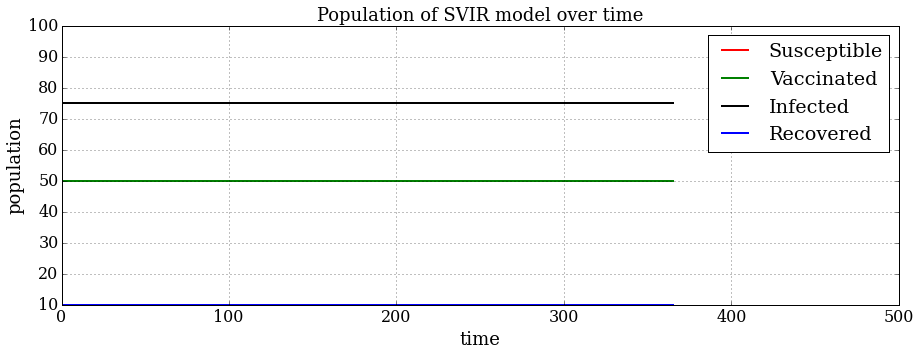

In [29]:
#Build slider for each parameter desired

pSlider = FloatSlider(description='p', min=0, max=1, step=0.1)
eSlider = FloatSlider(description='e', min=0, max=1, step=0.1)
muSlider = FloatSlider(description='mu', min=0, max=1, step=0.005)
betaSlider = FloatSlider(description='beta', min=0, max=.01, step=0.0005)
gammaSlider = FloatSlider(description='gamma', min=0, max=1, step=0.05)

#Update function will update the plotted graph every time a slider is changed

def update():
    
    """Returns a graph of the new results for a given slider parameter change.
    
    Parameters
    ----------
    p : float value of slider widget
    e : float value of slider widget
    mu : float value of slider widget
    beta : float value of slider widget
    gamma : float value of slider widget
        
    Returns
    -------
    Graph representing new populations
    """
    
    #the following parameters use slider.value to get the value of the given slider
    p = pSlider.value
    e = eSlider.value    
    mu = muSlider.value
    beta = betaSlider.value
    gamma = gammaSlider.value
    
    #inital population
    S0 = 100
    V0 = 50
    I0 = 75
    R0 = 10

    N = S0 + I0 + R0 + V0

    #Iteration parameters
    T = 365
    dt = 1
    N = int(T/dt)+1
    t = numpy.linspace(0, T, N)

    u = numpy.zeros((N,4))
    u[0] = [S0, V0, I0, R0]
    
    #Array of parameters
    init = numpy.array([p,e,mu,beta,gamma])

    for n in range(N-1):
        u[n+1] = euler_step(u[n], f, dt, init)
        
    #Plot of population with gicen slider parameters
    pyplot.figure(figsize=(15,5))
    pyplot.grid(True)
    pyplot.xlabel(r'time', fontsize=18)
    pyplot.ylabel(r'population', fontsize=18)
    pyplot.xlim(0, 500)
    pyplot.title('Population of SVIR model over time', fontsize=18)
    pyplot.plot(t,u[:,0], color= 'red', lw=2, label = 'Susceptible');
    pyplot.plot(t,u[:,1], color='green', lw=2, label = 'Vaccinated');
    pyplot.plot(t,u[:,2], color='black', lw=2, label = 'Infected');
    pyplot.plot(t,u[:,3], color='blue', lw=2, label = 'Recovered');
    pyplot.legend();
    
    #Clear the output otherwise it will create a new graph every time so you will end up with multiple graphs
    clear_output(True) #This ensures it recreates the data on the initial graph
    
#Run the update function on slider values change
pSlider.on_trait_change(update, 'value')
eSlider.on_trait_change(update, 'value')
muSlider.on_trait_change(update, 'value')
betaSlider.on_trait_change(update, 'value')
gammaSlider.on_trait_change(update, 'value')

    
display(pSlider, eSlider, muSlider, betaSlider, gammaSlider) #Display sliders
update() # Run initial function

Notice that the graph starts with all parameters equal to zero. Unfortunately we cannot set the initial value of the slider. We can work around this using conditional statements to see if the slider values are equal to zero, then use different parameters.

Notice that as you change the parameters the graph starts to come alive! This allows you to quickly compare how different parameters affect the results of our model!

## Dig deeper?

Using the ipywidget library, create a new function that allows for user input. Using the python array of objects below, which contains various diseases and their initial parameters, have the user type in one of the disease names and return the graph corresponding to that disease! You can use the ipywidget text box to take in the value from the user and then pass that value to a function that will call out that disease from the object below!




In [30]:
Disease = [{'name': "Ebola", 'p': 0, 'e': 0, 'mu': .04, 'beta': .005, 'gamma': 0}, \
           {'name': "Measles", 'p': .9, 'e': .9, 'mu': .02, 'beta': .002, 'gamma': .9}, \
           {'name': "Tuberculosis", 'p': .5, 'e': .2, 'mu': .06, 'beta': .001, 'gamma': .3}]

#Example

def z(x):
    print(x)
interact(z, x = 'Text')

Text


<function __main__.z>

## References

* Scherer, A. and McLean, A. "Mathematical Models of Vaccination", British Medical Bulletin Volume 62 Issue 1, 2015 Oxford University Press. [Online](http://bmb.oxfordjournals.org/content/62/1/187.long#F2)

* Barba, L., "Practical Numerical Methods with Python" George Washington University 

* For a good explanation of some of the simpler models and overview of parameters, visit this [Wiki Page](https://en.wikipedia.org/wiki/Epidemic_model)

* Slider tutorial posted on [github](https://github.com/ipython/ipywidgets/issues/145)





In [31]:
from IPython.core.display import HTML
css_file = 'numericalmoocstyle.css'
HTML(open(css_file, "r").read())